In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Tarefa 4 - Decision Trees, Random Forest and K-Means
Fourth assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using decision trees and random forests to solve a real-world problem in classification and delve into the world of unsupervised learning by implementing the K-means algorithm. Students will also get used to generating important plots during training to analyse the models' behaviour. 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Decision Trees](#Decision_Trees) (30%)
2. [Random Forest](#Random_Forest) (30%)
3. [K-Means](#K-Means) (30%)

### Decision_Trees
## Part 1 - Decision Trees for Classification (value: 30%)

In [14]:
# load the data
ddi_df = pd.read_csv('data/ddi_dt_sample.csv') # don't forget to change the path

In [15]:
# inspect the data
ddi_df.head(5)

,drug1,drug2,ddi,pca_max_0,pca_max_1,pca_max_2,pca_max_3,pca_max_4,pca_max_5,pca_max_6,...,pca_min_17,pca_min_18,pca_min_19,pca_min_20,pca_min_21,pca_min_22,pca_min_23,pca_min_24,pca_min_25,pca_min_26
0,CID000002725,CID000013342,0.0,-2.383210,-0.066904,0.051153,0.058145,0.398508,0.215271,-0.267814,...,-0.36635,-1.091191,-1.021989,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.09133,-0.195522
1,CID000002802,CID000013342,0.0,-2.554958,-0.066904,0.053715,0.058145,0.398508,0.131852,-0.267814,...,-0.36635,0.106596,0.010149,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
2,CID000002083,CID000013342,0.0,9.908402,-0.066904,0.122384,0.058145,0.398508,0.098734,0.041276,...,-0.36635,0.102901,0.010149,-0.088365,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
3,CID000004034,CID000013342,0.0,-2.547375,-0.066904,0.051884,0.058145,0.398508,0.203962,-0.267814,...,-0.36635,-1.011102,-0.944133,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522
4,CID000003899,CID000013342,0.0,-2.554958,-0.066904,0.051083,0.058145,0.398508,0.138126,-0.267814,...,-0.36635,0.075010,0.010149,-0.086979,-0.326333,-0.17953,-0.162906,-0.204593,-0.08010,-0.195522


As you can observe, the first 2 columns represent the IDs of the drugs in each combination. The 3rd column represents the binary label indicating if the pair causes an adverse interaction or not. The remaining 54 columns are the features based on the PCA representations of individual drug targets. 

In [16]:
#Functions
###----- accuracy_score-----###
def accuracy_score(y_true, y_pred):
        """
        calculate accuracy.
        
        Args:
            y_true: true labels.
            y_pred: predicted labels class.
        """
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        accuracy = correct_predictions / total_predictions
        return accuracy

#Classes
###----- node -----###
class TreeNode:
    """
    node in a decision tree.
    """
    def __init__(self, data, feature_idx, feature_val, entropy):
        """
        initialize the TreeNode.

        Args:
            data: datapoints in the node. (features and target)
            feature_idx: index of the feature used for splitting.
            feature_val: value of the feature used for splitting. (<=)
            entropy: entropy of the node.
        """
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.entropy = entropy
        self.left = None
        self.right = None

    @property
    def is_leaf(self):
        """
        checks if the node is a leaf.
        """
        return self.left is None and self.right is None
    
###----- tree -----###
class DecisionTree:
    """
    decision tree classifier (2 classes).
    """
    def __init__(self, max_depth = 10, min_samples_leaf=1, num_features=None, random_state=None):
        """
        initialize the DecisionTree.

        Args:
            max_depth: maximum depth that the tree can growth.
            min_samples_leaf: minimum number of samples required to be at a leaf node.
            num_features: number of features to consider for splitting.
            random_state: seed for random generation.
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.num_features = num_features
        self.random_state = random_state
        self.tree = None

    def fit(self, X_train, y_train):
        """
        fit the decision tree to the training data.
        """
        if self.num_features is None: #check if num_features is not specified and set it to the number of features in the training data.
            self.num_features = X_train.shape[1]
        
        train_data = np.column_stack((X_train, y_train)) #combine features and target
        
        #select features based on num_features.
        rng = np.random.default_rng(self.random_state) 
        selected_features = rng.choice(range(X_train.shape[1]), size=self.num_features, replace=False)
        selected_features.sort()
        
        #create the decision tree
        self.tree = self._create_tree(train_data, 0, selected_features)  # 

    def predict(self, X_test):
        """
        predict positive class frequency for new data.
        """
        predictions = np.array([self._predict_sample(x, self.tree) for x in X_test])
        return predictions
    
    def print_tree(self):
        """
        print the decision tree in the terminal.
        """
        self._print_tree(self.tree)

    def _create_tree(self, data, current_depth, selected_features):
        """
        recursively growth the decision tree.
        """
        if current_depth > self.max_depth:
            return None
        
        #find the best split
        split_data, split_feature_idx, split_feature_val = self._find_bestsplit(data, selected_features)

        node = TreeNode(data, split_feature_idx, split_feature_val, self._entropy(data[:, -1]))
        
        if split_data is None: #if no split is possible, return the current node as a leaf.
            return node
        
        if node.entropy == 0:
            return node
        
        #check if the number of samples in the current split is less than the minimum
        #(maybe useless, bacause i already did it in find_bestsplit)
        if len(split_data[0]) < self.min_samples_leaf or len(split_data[1]) < self.min_samples_leaf:
            return node

        #recursively create left and right child nodes.
        current_depth += 1
        node.left = self._create_tree(split_data[0], current_depth, selected_features)
        node.right = self._create_tree(split_data[1], current_depth, selected_features)

        return node

    def _find_bestsplit(self, data, selected_features):
        """
        find the best split for the current node. search all features sellected.
        """
        if isinstance(data, pd.DataFrame):
            data = data.values
        if isinstance(data, pd.Series):
            data = data.values
        
        best_info_gain = -float('inf')
        best_feature_index = None
        best_tau = None
        regions = None
        
        for feature_index in selected_features: 
            feature_values = data[:, feature_index]
            possible_taus = np.unique(feature_values) #get the unique feature values, to iterate through in this values.
            
            for tau in possible_taus:
                #split the data
                left, right = self._split(data, feature_index, tau)
                
                #calculate information gain
                info_gain = self._information_gain(data[:, -1], left[:, -1], right[:, -1])
                
                #update best split based on info_gain, but just if the split has the minimum samples.
                if info_gain > best_info_gain and\
                len(left)>=self.min_samples_leaf and\
                len(right)>=self.min_samples_leaf: #
                    best_info_gain = info_gain
                    best_feature_index = feature_index
                    best_tau = tau
                    regions = (left, right)

        return regions, best_feature_index, best_tau

    def _split(self, data, feature_index, tau):
        """
        split the data based on a feature and threshold. 
        left <= threshold
        right > threshold
        """
        if isinstance(data, pd.DataFrame):
            feature_values = data.iloc[:, feature_index].values
        else:
            feature_values = data[:, feature_index]
            
        left_indices = np.where(feature_values <= tau)[0] 
        right_indices = np.where(feature_values > tau)[0] 
        
        #get the data from indices
        left_partition = data[left_indices]
        right_partition = data[right_indices]
        
        return left_partition, right_partition

    def _entropy(self, y):
        """
        calculate the entropy of a node.
        """
        if len(y) == 0:
            return 0
        
        p1 = np.mean(y)
        
        if p1 == 0 or p1 == 1:
            return 0
        
        return -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1) #entropy for binary classification

    def _information_gain(self, parent, left, right):
        """
        calculate information gain.
        """
        #entropy for the parent, left, and right nodes.
        parent_entropy = self._entropy(parent)
        left_entropy = self._entropy(left)
        right_entropy = self._entropy(right)
        
        #number of data points in the parent, left, and right nodes.
        n = len(parent)
        n_left = len(left)
        n_right = len(right)
        
        #weighted average entropy
        weighted_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy #binary classification
        
        return parent_entropy - weighted_entropy
    
    def _predict_sample(self, sample, node):
        """
        predict positive class frequecy for a single instance.
        """
        if node.is_leaf:
            return np.mean(node.data[:, -1]) #positive class frequency (positive class has value 1)
        if sample[node.feature_idx] <= node.feature_val:
            return self._predict_sample(sample, node.left) #recursively predict using the left node.
        else:
            return self._predict_sample(sample, node.right) #recursively predict using the right node.

    def _print_tree(self, node, depth=0, prefix=""):
        """
        recursively print the decision tree.
        """
        if node is None:
            return
        indent = "  " * depth
        if node.is_leaf:
            #print(f"{indent}{prefix}Leaf: Value {np.mean(node.data[:, -1]):.2f}, Samples: {len(node.data)}, Entropy = {node.entropy:.2f}")
            print(f"{indent}{prefix}Leaf: Value {[len(node.data[node.data[:,-1] == 0]), len(node.data[node.data[:,-1] == 1])]}, Samples: {len(node.data)}, Entropy = {node.entropy:.2f}")
        else:
            print(f"{indent}{prefix}Node: Feature {node.feature_idx}, Threshold {node.feature_val:.2f}, Entropy = {node.entropy:.2f}")
            self._print_tree(node.left, depth + 1, prefix="L--> ")
            self._print_tree(node.right, depth + 1, prefix="R--> ")

###----- gridsearch -----###
class GridSearchTree:
    """
    grid search for the best hyperparameters.
    """
    def __init__(self, model_class, param_grid, cv=3, random_state = None):
        """
        initialize the grid search.
        
        Args:
            model_class: model to be used.
            param_grid (dict): {'max_depth': [...], 'min_samples_leaf': [...]}
            cv: number of folds for cross-validation.
            random_state: seed for random generation.
        """
        self.model_class = model_class
        self.param_grid = param_grid
        self.cv = cv
        self.random_state = random_state
        self.best_params_ = None
        self.best_score_ = None
        self.results_ = []

    def fit(self, X, y):
        """
        perform grid search to find the best hyperparameters.
        """
        best_score = (-float('inf'), -float('inf'))
        best_params = None

        #generate all combinations of hyperparameters
        param_combinations = self._create_param_combinations(self.param_grid)

        for params in param_combinations:
            max_depth = params['max_depth']
            min_samples_leaf = params['min_samples_leaf']
            
            accuracies = []
            aucs = []

            #split indices into folds for cross-validation.
            indices = np.arange(X.shape[0])
            rng = np.random.default_rng(self.random_state)
            rng.shuffle(indices)
            fold_sizes = np.full(self.cv, X.shape[0] // self.cv, dtype=int)
            fold_sizes[:X.shape[0] % self.cv] += 1 #ensure all samples are used

            current = 0
            for fold_size in fold_sizes:
                #split data into training and validation sets
                val_indices = indices[current:current + fold_size]
                train_indices = np.concatenate([indices[:current], indices[current + fold_size:]])
                current += fold_size

                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]
                
                #fit the model
                model = self.model_class(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
                model.fit(X_train, y_train)
                
                #predict
                y_pred = model.predict(X_val)
                y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]
                
                #scores
                accuracy = accuracy_score(y_val, y_pred_class)
                auc = roc_auc_score(y_val, y_pred)
                
                accuracies.append(accuracy)
                aucs.append(auc)
            
            mean_accuracy = np.mean(accuracies)
            mean_auc = np.mean(aucs)
            score = (mean_auc, mean_accuracy)
            
            self.results_.append({
                'params': params,
                'mean_accuracy': mean_accuracy,
                'mean_auc': mean_auc})
            
            if score[0] > best_score[0]: #use AUC to select the best model
                best_score = score
                best_params = params

        self.best_params_ = best_params
        self.best_score_ = best_score

    def _create_param_combinations(self, param_grid):
        """
        create all combinations of hyperparameters to be tested.
        """
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        combinations = []

        def create_combinations(current_combination, index):
            """
            recursively create combinations of hyperparameters.
            needed because the combinations are stored in a dict.
            """
            if index == len(keys):
                combinations.append(dict(current_combination))
                return
            key = keys[index]
            for value in values[index]:
                current_combination[key] = value
                create_combinations(current_combination, index + 1)

        create_combinations({}, 0)
        return combinations

In [17]:
##your code goes here:
X = ddi_df.iloc[:,3:].values  # Features
y = ddi_df.iloc[:, 2].values # Target variable

#perform an 90/10 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

best_depth = None
best_score = -float('inf')

#define the hyperparameters
param_grid = {
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [15]
}

#grid search
grid_search = GridSearchTree(DecisionTree, param_grid, cv=3, random_state=13)
grid_search.fit(X_train, y_train)

#grid search results
print(f"Best Params: {grid_search.best_params_}")
max_depth = grid_search.best_params_["max_depth"]

Best Params: {'max_depth': 6, 'min_samples_leaf': 15}


In [18]:
#best model with the optimal hyperparameters.
best_model = DecisionTree(max_depth=max_depth, min_samples_leaf=15)
best_model.fit(X_train, y_train)

#predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_class = [1 if pred > 0.5 else 0 for pred in y_pred]

#final accuracy and AUROC score
final_accuracy = accuracy_score(y_test, y_pred_class)
final_auc = roc_auc_score(y_test, y_pred)

print(f"Final Test Accuracy: {final_accuracy:.4f}, Final Test AUROC: {final_auc:.4f}")

#best_model.print_tree()

Final Test Accuracy: 0.7949, Final Test AUROC: 0.8603


## Random_Forest
## Part 2 - Random Forest for Classification Networks (value: 30%)



In [19]:
def bootstrap(X, num_bags, random_state = None):
    """
    create bootstrap samples from the input data
    """
    rng = np.random.default_rng(random_state) 
    num_samples = len(X)
    bags = []
    for _ in range(num_bags):
        indices = rng.choice(num_samples, size=num_samples, replace=True) #sample with replacement
        bags.append(indices)

    return bags

#Classes
###----- randomforest -----###
class RandomForest:
    """
    random forest classifier.
    """
    def __init__(self, num_features, num_estimators, min_samples_leaf=15, max_depth=6, random_state=None):
        """
        initialize the RandomForest.

        Args:
            num_features: number of features to consider for splitting.
            num_estimators: numberr of decision tree estimators.
            max_depth: maximum depth that the tree can growth.
            min_samples_leaf: minimum number of samples required to be at a leaf node.
            random_state: seed for random generation.
        """
        self.num_features = num_features
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.num_estimators = num_estimators
        self.random_state = random_state
        self.estimators = []

    def fit(self, X_train, y_train):
        """
        fit the random forest classifier to the training data.
        """
        #bootstrap samples of indices
        bag_indices = bootstrap(X_train, self.num_estimators, self.random_state)
        
        #create individual decision tree estimators
        for i in range(self.num_estimators):
            indice = bag_indices[i]
            bag_X = X_train[indice]
            bag_y = y_train[indice]
            
            #create the decision tree
            randomforest_estimator = DecisionTree(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, num_features=self.num_features, random_state=(self.random_state + i*2)) #
            randomforest_estimator.fit(bag_X, bag_y)
            
            self.estimators.append(randomforest_estimator) #append the decision tree to the list (forest).

    def predict(self, X):
        """
        predict positive class frequency for new data. 
        user the binary estimation from each estimator.
        """
        predictions = []
        
        #iterate through each estimator
        for estimator in self.estimators:
            pred = estimator.predict(X)
            pred_class = [1 if pred_sample > 0.5 else 0 for pred_sample in pred] #convert to class labels
            predictions.append(pred_class)
        
        return np.mean(predictions, axis=0) #positive class frequency (positive class has value 1)

In [20]:
## your code goes here:
def evaluate_random_forest(X_train, y_train, X_val, y_val):
    """
    search the optimal hyperparameter configuration.
    """
    best_auroc = -1
    best_params = None

    #num_features = raiz(total_features)
    num_features = round(np.sqrt(X_train.shape[1]))
    
    #combinations of hyperparameters to be tested.
    param_combinations = [
        {'num_features': num_features, 'min_samples_leaf': 15, 'max_depth': 6, 'num_estimators': 10},
        {'num_features': num_features, 'min_samples_leaf': 20, 'max_depth': 8, 'num_estimators': 15},
        {'num_features': num_features, 'min_samples_leaf': 25, 'max_depth': 10, 'num_estimators': 20},
        {'num_features': num_features, 'min_samples_leaf': 15, 'max_depth': 6, 'num_estimators': 25},
        {'num_features': num_features, 'min_samples_leaf': 20, 'max_depth': 8, 'num_estimators': 30}
    ]

    for params in param_combinations:
        #train the model
        randomforest = RandomForest(**params, random_state=13)
        randomforest.fit(X_train, y_train)
        
        y_pred = randomforest.predict(X_val) #predict
        
        auroc = roc_auc_score(y_val, y_pred) #score

        if auroc > best_auroc:
            best_auroc = auroc
            best_params = params

    return best_params, best_auroc

#split the data into training, validation, and test sets.
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size=0.8, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=13)

#evaluate the random forest model
best_params, best_auroc = evaluate_random_forest(X_train, y_train, X_val, y_val)
print(f"Melhores parâmetros encontrados: {best_params}")
#print(f"AUROC no conjunto de validação: {best_auroc:.4f}")

#train the best model using the combined training and validation data.
best_randomforest = RandomForest(**best_params, random_state=13)
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

best_randomforest.fit(X_train_val, y_train_val)

#scoring the best model on the test set
y_pred = best_randomforest.predict(X_test)
test_auroc = roc_auc_score(y_test, y_pred)
print(f"AUROC no conjunto de teste: {test_auroc:.4f}")

Melhores parâmetros encontrados: {'num_features': 7, 'min_samples_leaf': 20, 'max_depth': 8, 'num_estimators': 30}
AUROC no conjunto de teste: 0.8892


Comparando o melhor modelo da parte 1, com o melhor modelo da parte 2, vemos que a Random Forest tem uma performace superior no nosso conjunto de dados. Como segue:

In [21]:
#training the best random forest
randomforest = RandomForest(**best_params, random_state=13)
randomforest.fit(X_train_val, y_train_val)

#scoring the best random forest
y_pred_rf = best_randomforest.predict(X_test)
final_auroc_rf = roc_auc_score(y_test, y_pred_rf)

#training the best decision tree
best_model = DecisionTree(max_depth=max_depth, min_samples_leaf=15)
best_model.fit(X_train_val, y_train_val)

#scoring the best decision tree
y_pred_t = best_model.predict(X_test)
final_auroc_t = roc_auc_score(y_test, y_pred_t)

print(f"Decision Tree (AUROC): {final_auroc_t:.4f}")
print(f"Random Forest (AUROC): {final_auroc_rf:.4f}")

Decision Tree (AUROC): 0.8694
Random Forest (AUROC): 0.8892


## K-Means
## Part 3 – Clustering with K-means (value: 40%)

In this exercise, you will explore clustering by implementing the K-means algorithm. You will write code to perform K-means clustering while visualizing the movement of the centroids at each iteration. 

To complete this exercise, you will write code to implement K-means for clustering: 

1. Dataset Preparation: Run the cells provided in the notebook that generate the artificial data points for this exercise.
2. K-means Clustering:
	- Initialize K cluster centroids by selecting K points from your dataset at random.
	- Implement a loop to perform the following steps until convergence (or until a specified maximum number of iterations is reached, e.g., 150):
        - Assign each data point to the nearest centroid (you will have to calculate the Euclidean distance between the data point and each centroid).
        - Update each centroid by moving it to the mean of all data points assigned to it.
        - Check for convergence by comparing the new centroids with the previous centroids. If the difference is smaller than an $\epsilon=1^{-4}$, exit the loop.
3. Centroid Movement Visualization:
	- At 5 different moments during training, plot a figure showing the centroids and the points. Figure 1 should show the situation at the beginning, before learning. Figure 5 should show the situation at the end of the learning. The remaining Figures 2-4 should show intermediary situations.
	- For each figure, each centroid will be represented by a large black cross and each cluster with a different colour, the points must be coloured according to their respective cluster.
4. Sum of squared distances:
	- Along with plotting the centroid movement, calculate the sum of squared distances at each iteration as follows:
        - $\sum_{j=1}^K \sum_{n \in S_j}d(x_n,\mu_j )^2$, where $K$ is the number of clusters, $x_n$ represents the $n^{th}$ datapoint, $n \in S_j$ indicates a set of points that belong to cluster $S_j$, $\mu_j$ is the mean of the datapoints in $S_j$ and $d(x_n,\mu_j)$ indicates the Euclidean distance between $x_n$ and $\mu_j$.
	- Make a plot of the sum of squared distances at each iteration. 


In [22]:
# Generate artificial data points
np.random.seed(13)
num_samples = 200
num_features = 2
X = np.random.randn(num_samples, num_features) * 1.5 + np.array([[2, 2]])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 3 + np.array([[-5, -5]])])
X = np.concatenate([X, np.random.randn(num_samples, num_features) * 2 + np.array([[7, -5]])])

In [28]:
class KMeans:
    """
    k-means clustering.
    """
    def __init__(self, n_clusters=3, max_iter=150):
        """
        initialize the KMeans.

        Args:
            n_clusters: the number of clusters.
            max_iter: maximum number of iterations.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels_ = None
        self.ss_distances = []
        self.iteration_data = []

    def fit(self, X):
        """
        compute k-means clustering.
        """
        #initialize centroids selecting points at random.
        initial_centroids_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[initial_centroids_indices]
        
        for _ in range(self.max_iter):
            #calculate the distance for each point
            distances = []
            for point in X:
                #calculate the distance
                distance_to_centroids = [np.linalg.norm(point - centroid) for centroid in self.centroids]
                distances.append(distance_to_centroids)
            distances = np.array(distances)
            
            #assign each instance to the nearest centroid
            self.labels_ = np.argmin(distances, axis=1)

            #update each centroid
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = X[self.labels_ == k] #find the data points that belong to the cluster
                centroid = cluster_points.mean(axis=0) #find new cluster position
                new_centroids.append(centroid)
            new_centroids = np.array(new_centroids)
            
            #check if the difference between new and old centroids is lower than 1e-4
            if np.abs(self.centroids - new_centroids).sum() < 1e-4:
                break
            
            #save data for plotting later
            self.ss_distances.append(sum([np.linalg.norm(X[self.labels_ == k] - self.centroids[k])**2 for k in range(self.n_clusters)]))
            self.iteration_data.append((self.centroids.copy(), self.labels_.copy()))

            self.centroids = new_centroids #define the centroid as new centroids
        
    def plot_iterarions(self):
        """
        plot the clusters at specific iterations during the KMeans fitting process.
        """
        #define the iterations to plot
        num_iterations = len(self.iteration_data)
        print(f"O número de iterações necessárias para convergencia foi: {num_iterations}")
        steps = [0, num_iterations // 4, num_iterations // 2, 3 * num_iterations // 4, num_iterations - 1]
        
        #plot the selected iterations
        for i, step in enumerate(np.unique(steps)):
            centroids, labels = self.iteration_data[step]
            iteration_label = 'begin' if step == 0 else ('final' if step == num_iterations - 1 else step + 1)
            self.plot_clusters(X, centroids, labels, iteration=iteration_label)

    def plot_clusters(self, X, centroids, labels, iteration):
        """
        plot the clusters and their centroids.
        """
        plt.figure(figsize=(8, 6))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k] #select data points that belong to the cluster
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}') #plot the points from each cluster
        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids') #plot centroids
        plt.title(f'Iteration {iteration}')
        plt.legend()
        plt.show()

    def plot_sum_of_squared_distances(self):
        """
        plot the sum of squared distances at each iteration.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.ss_distances) + 1), self.ss_distances, marker='o', color='b')
        plt.title('Sum of Squared Distances')
        plt.xlabel('Iteration')
        plt.ylabel('SSD')
        plt.grid(True, alpha=0.2)
        plt.show()

O número de iterações necessárias para convergencia foi: 10


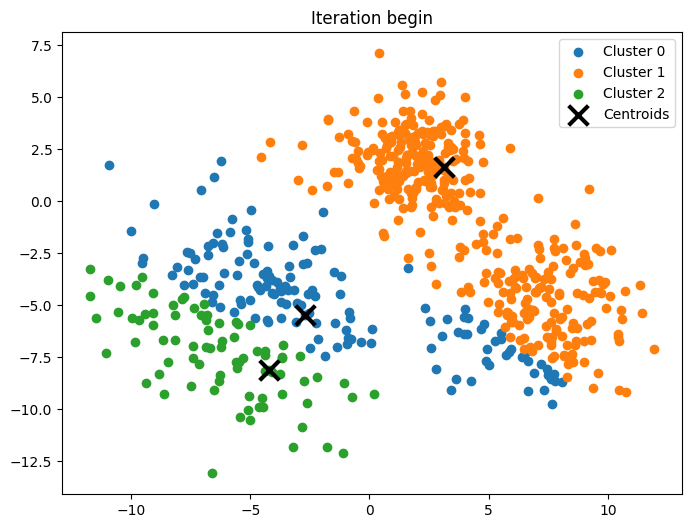

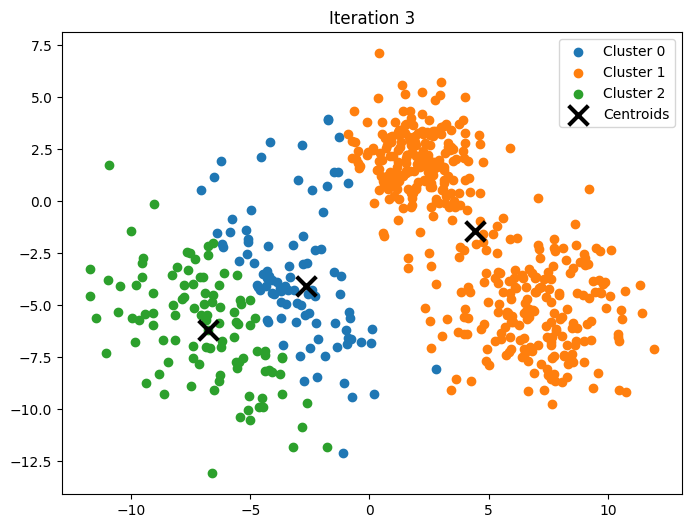

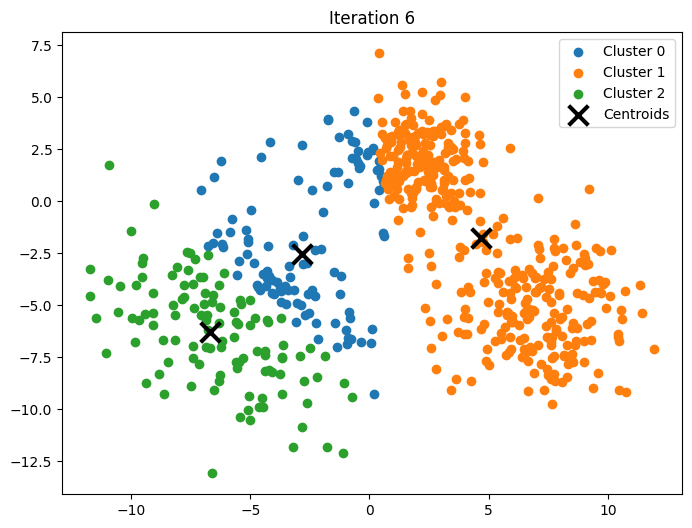

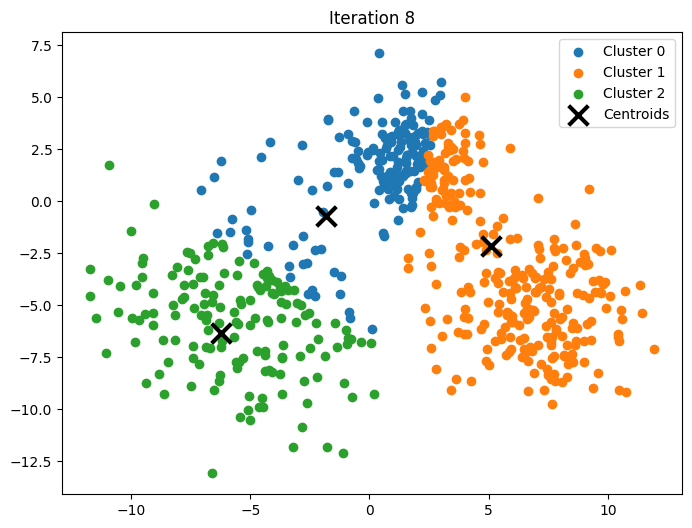

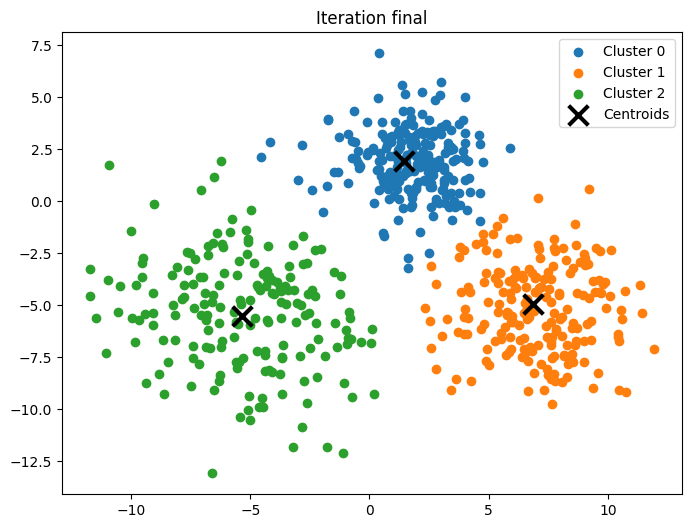

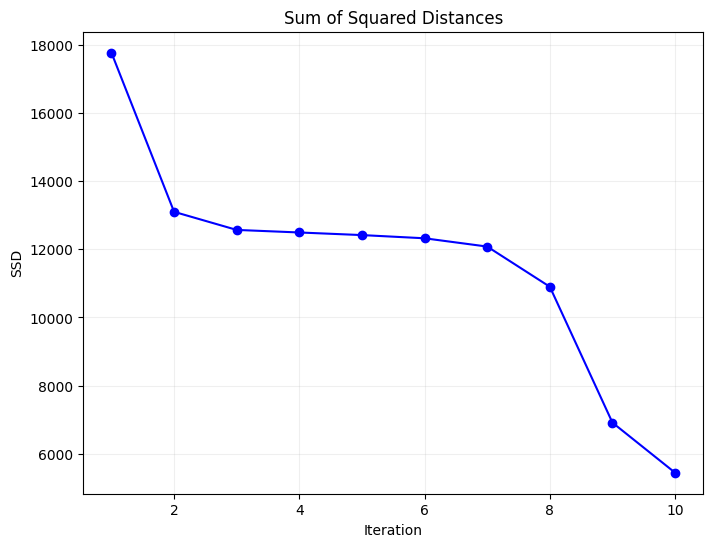

In [30]:
## your code goes here:
kmeans = KMeans(n_clusters=3, max_iter=150)
kmeans.fit(X)

#plot the sum of squared dsitances
kmeans.plot_iterarions()
kmeans.plot_sum_of_squared_distances()